In [4]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Download some sample data

In [97]:
import priceanalytics.data as data

big_df = data.alpaca_download_single(
    'AAPL',     
    past_days=30, 
    interval=1
)
dfs = data.split_alpaca_on_day(big_df)

## Square Bounds algorithm


$$ \text{Opening and closing price series are defined by}\  O(t) \ \text{and} \ C(t) \ \text{respectively from time 0, while}\ \alpha\ \text{is an arbitrary constant.} $$

$$ u(t) = \max( O(t),\ C(t),\ u(t-1) - \frac{u(t-1) - C(t)}{\alpha}) $$

$$ d(t) = \min( O(t),\ C(t),\ d(t-1) + \frac{C(t) - d(t-1)}{\alpha}) $$

$$ U(t) = \max( O^2(t),\ C(t)^2,\ U^2(t-1) - \frac{U(t-1) - C^2(t)}{\alpha}) $$

$$ D(t) = \min( O^2(t),\ C(t)^2,\ D^2(t-1) + \frac{C^2(t) - D(t-1)}{\alpha}) $$

$$ B(t) = \sqrt{U(t)-u^2(t)} $$

$$ b(t) = -\sqrt{D(t)-d^2(t)} $$

$$ \text{Enter a long position when }\frac{dB}{dt}(T) < 0 \text{ and }b(T)=0 \text{, and enter a short position when } \frac{db}{dt}(T) > 0\text{.} $$


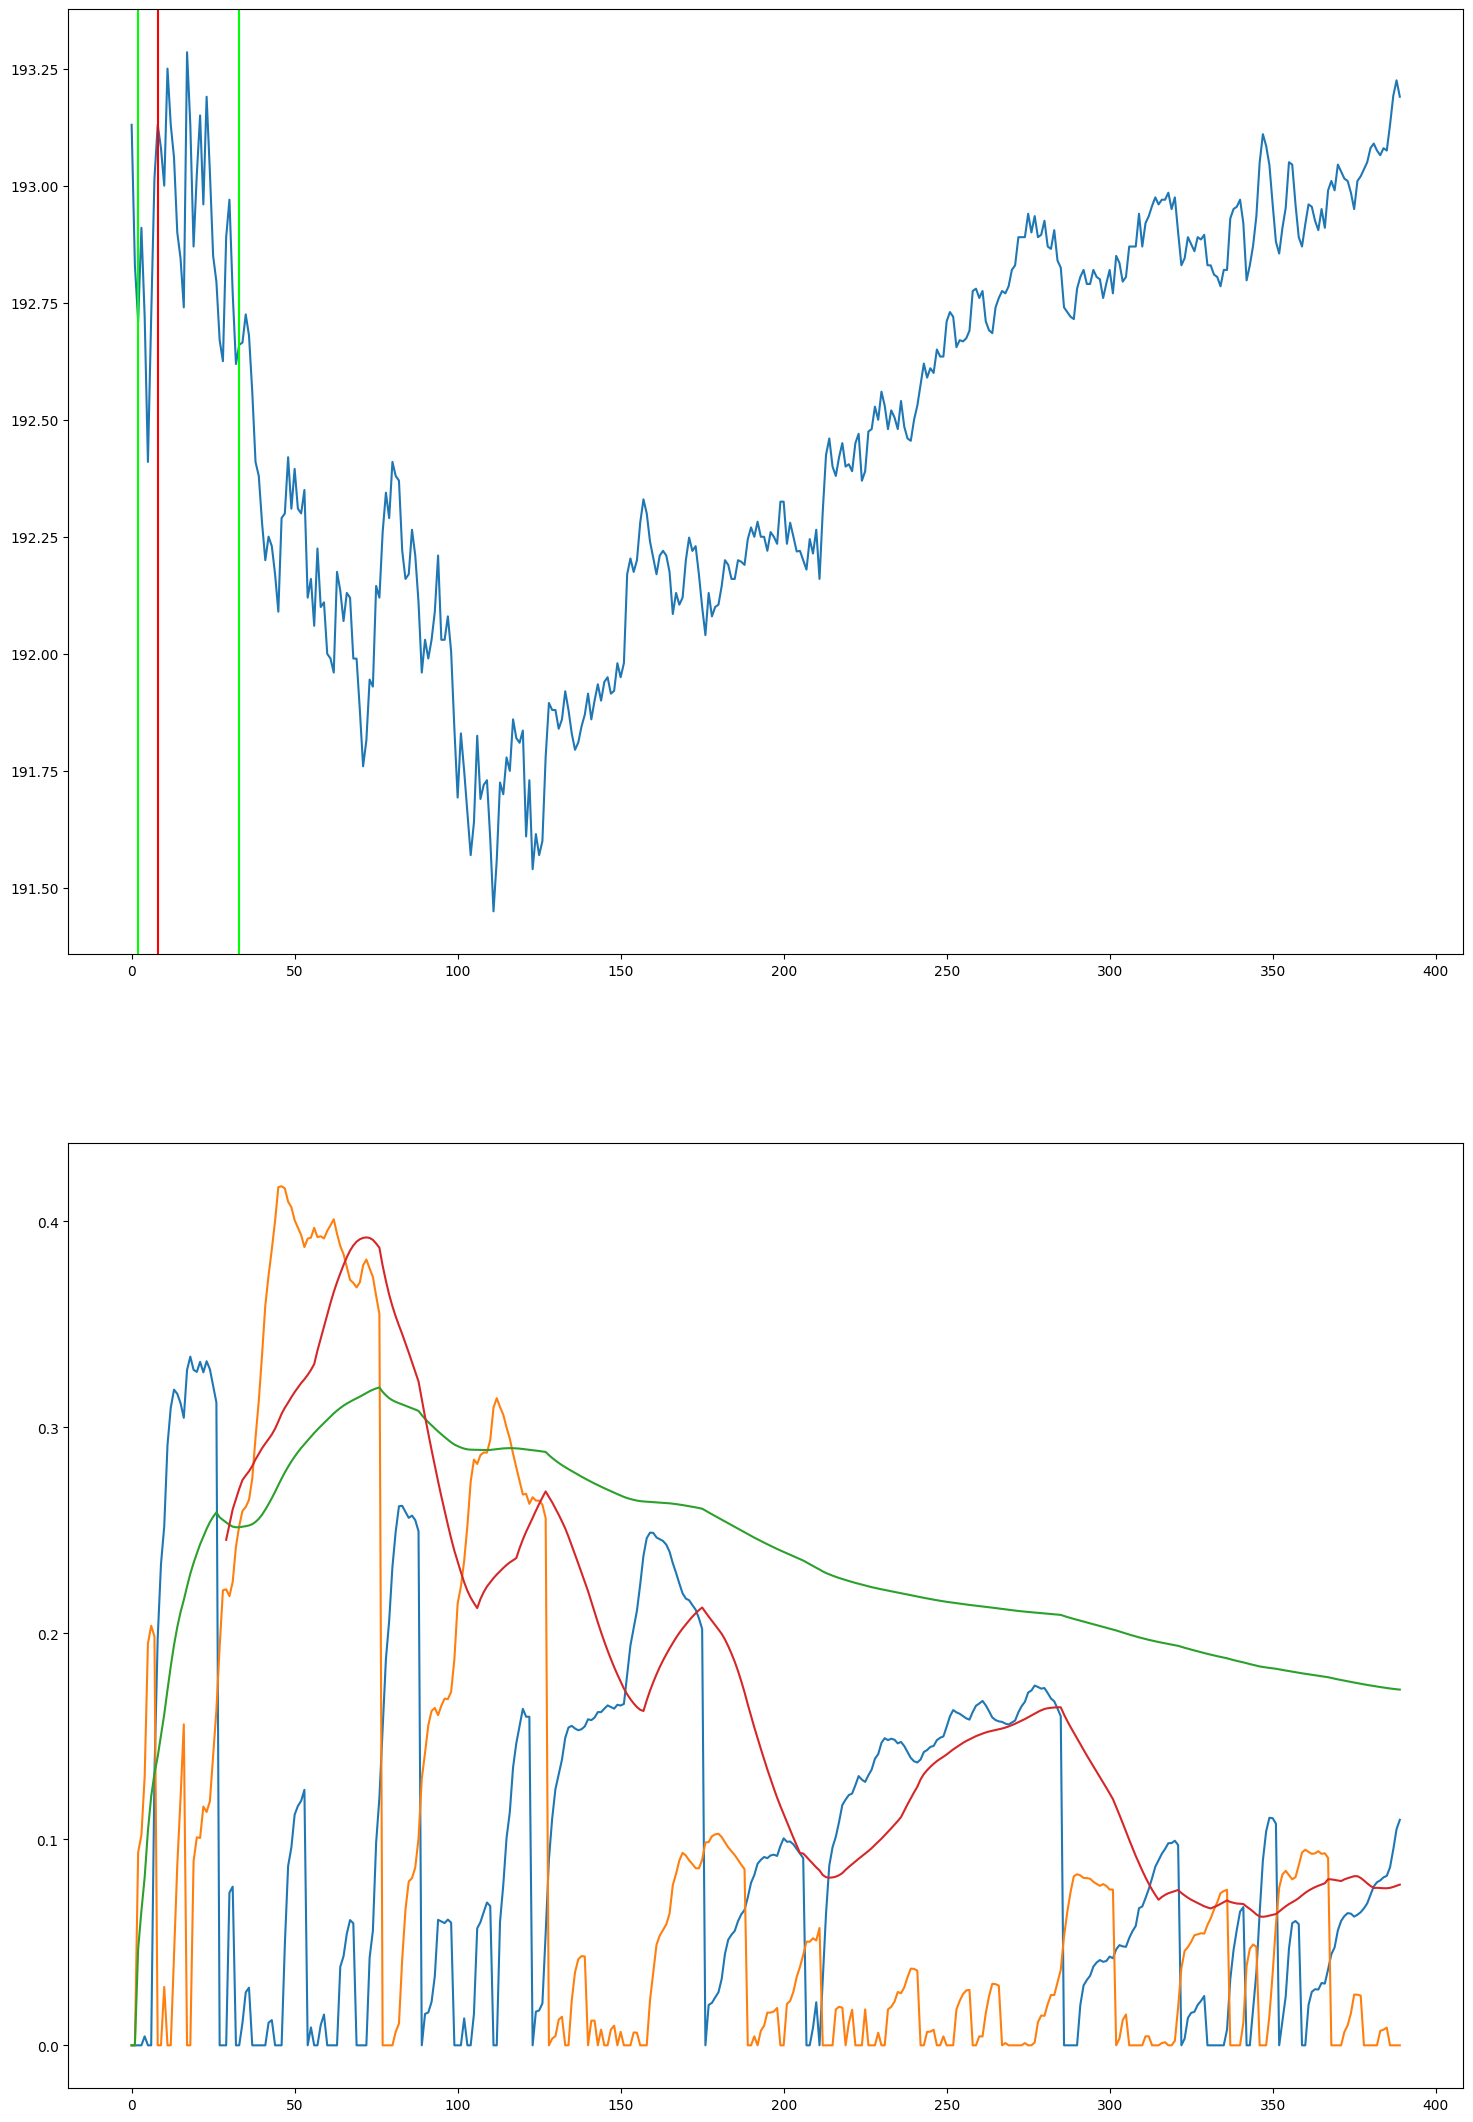

In [125]:
import pandas as pd
import numpy as np
import priceanalytics.plot as plot
import matplotlib.pyplot as plt

def roll(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def _diff(x):
    N = len(x)
    y, _ = np.zeros((2, N))
    for i in range(1, N):
        y[i] = x[i] - x[i-1]
    return y
    
def numpy_ewma_vectorized_v2(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

def sb(close, _open):

    N = len(close)
#     alpha = 2 / (_len + 1)
#     alpha_sig = 2 / (sig_len + 1)
    alpha = 20

    up1, up2, dn1, dn2, bull, bear, bull_mean, bear_mean, max_avg, min_avg = np.zeros((10, N))

    up1[0] = dn1[0] = close[0]
    up2[0] = dn2[0] = close[0] ** 2
       
    for i in range(1, N):
        
        up1[i] = max(close[i], _open[i], up1[i - 1] - (up1[i - 1] - close[i]) / alpha)
        dn1[i] = min(close[i], _open[i], dn1[i - 1] + (close[i] - dn1[i - 1]) / alpha)

        up2[i] = max(close[i] ** 2, _open[i] ** 2, up2[i - 1] - (up2[i - 1] - close[i] ** 2) / alpha)
        dn2[i] = min(close[i] ** 2, _open[i] ** 2, dn2[i - 1] + (close[i] ** 2 - dn2[i - 1]) / alpha)
             
        bear[i] = np.sqrt(up2[i] - up1[i] ** 2)
        bull[i] = np.sqrt(dn2[i] - dn1[i] ** 2) 

        bear_mean[i] = np.sum(bear) / i
        bull_mean[i] = np.sum(bull) / i

        max_avg[i] = np.sum(np.maximum(bear, bull)) / i
        min_avg[i] = np.sum(np.minimum(bear, bull)) / i

    #bear *= -1
    
    max_mavg = pd.Series(np.maximum(bull, bear)).rolling(30).mean().to_numpy()

    sig = numpy_ewma_vectorized_v2(np.maximum(bear, bull), 3)

    d = np.maximum(bear, bull) - sig
        
    inpos = False
    longs, shorts = [], []
    
    for i in range(2, N-1):
        #if not inpos and (bear[i] - bear[i-1]) > (bear[i-1] - bear[i-2]) and (bear[i] - bear[i-1]) != 0:
        if not inpos and bear[i] > max_avg[i]:# and bear[i-1] < max_avg[i-1]:
            inpos = True
            longs.append(i)
 
        # elif inpos and (bull[i] - bull[i-1]) > (bull[i-1] - bull[i-2]) and (bull[i] - bull[i-1]) != 0:
        elif inpos and bull[i] > max_avg[i]:# and bull[i-1] < max_avg[i-1]:
            inpos = False
            shorts.append(i)
            
    with plot.MultiPlot(2, size=(18, 9 * 3)) as m:
        plt.plot(close)

        for long in longs:
            plt.axvline(x=long, color="#00FF00")
        for short in shorts:
            plt.axvline(x=short, color="#FF0000")
       
        
        #plt.plot(up1)
        #plt.plot(np.sqrt(up2))
            
        #plt.plot(dn1)
        #plt.plot(np.sqrt(dn2))
     
        m.next()
        
        plt.plot(bull)
        #plt.plot(bull_mean)

        plt.plot(bear)
        #plt.plot(bear_mean)
        plt.plot(max_avg)
        plt.plot(max_mavg)
        # plt.plot(min_avg)

        #plt.plot(sig)

        # plt.plot(d)

       

    
#         plt.plot(bear_ma)

        
#         m.next()
        
#         plt.plot(bull_1st_ddt)
#         plt.plot(bull_2nd_ddt)
#         #bear_1st_ddt, bear_2nd_ddt
        
      
    
    #return df


def test_sb(df):
    
    
    close = df['close'].to_numpy()
    _open = df['open'].to_numpy()
    
    sb(close, _open)
    

test_sb(dfs[-10].copy())

# 

bull > bear = enter long
bull < sig = exit long
bull < bear = enter short


## Todo tommorow

- play around w/ the formula a little more
- maybe mess with alpha a bit (; 
- implement a proper backtesting notebook
- maybe make a testing script for tuning alpha parameters + many datapoints
- implement gradient algorithm in go (cry) with testcases (supercry)

## An interesting problem

$$ g(v)\ \text{is a function of vector}\ v\ \text{which yields a vector 

bull-bear? 